# Steam User Suggestion Prediction 

***This code script used steam review data to predict user suggestion.***

In [1]:
# load packages
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
# nlp 
import nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from sklearn.feature_extraction.text import CountVectorizer
# word embedding
import gensim 
from gensim.models import Word2Vec
# sentiment
from textblob import TextBlob
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import r2_score

## Load dataset

In [2]:
steam_train = pd.read_csv("train.csv")
overview = pd.read_csv("game_overview.csv")
steam_test = pd.read_csv("test.csv")

In [3]:
steam_train.head(3)

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1


In [4]:
overview.head(3)

,title,developer,publisher,tags,overview
0,Spooky's Jump Scare Mansion,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...
1,Sakura Clicker,Winged Cloud,Winged Cloud,"['Nudity', 'Anime', 'Free to Play', 'Mature', ...",The latest entry in the Sakura series is more ...
2,WARMODE,WARTEAM,WARTEAM,"['Early Access', 'Free to Play', 'FPS', 'Multi...",Free to play shooter about the confrontation o...


In [3]:
# join train data with overview data
df_steam = pd.merge(steam_train, overview, how='left', on='title')
df_steam.head(3)

,review_id,title,year,user_review,user_suggestion,developer,publisher,tags,overview
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...


In [4]:
# join test data with overview data
df_test = pd.merge(steam_test, overview, how='left', on='title')
df_test.head(3)

,review_id,title,year,user_review,developer,publisher,tags,overview
0,1603,Counter-Strike: Global Offensive,2015.0,"Nice graphics, new maps, weapons and models. B...","Valve, Hidden Path Entertainment",Valve,"['FPS', 'Multiplayer', 'Shooter', 'Action', 'T...",Counter-Strike: Global Offensive (CS: GO) expa...
1,1604,Counter-Strike: Global Offensive,2018.0,I would not recommend getting into this at its...,"Valve, Hidden Path Entertainment",Valve,"['FPS', 'Multiplayer', 'Shooter', 'Action', 'T...",Counter-Strike: Global Offensive (CS: GO) expa...
2,1605,Counter-Strike: Global Offensive,2018.0,Edit 11/12/18I have tried playing CS:GO recent...,"Valve, Hidden Path Entertainment",Valve,"['FPS', 'Multiplayer', 'Shooter', 'Action', 'T...",Counter-Strike: Global Offensive (CS: GO) expa...


## EDA

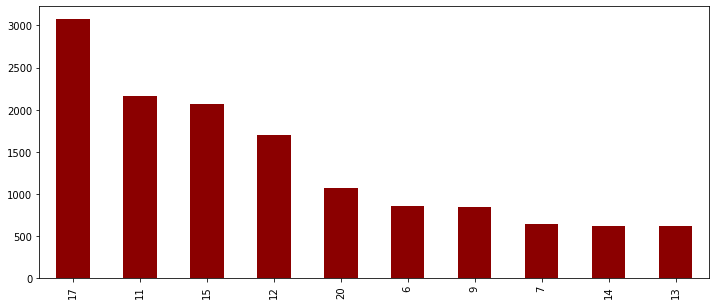

In [9]:
df_steam['reviewLength'] = df_steam['user_review'].apply(lambda x:len(str(x)))
plt.figure(figsize=(12,5))
df_steam['titleLength'].value_counts().head(10).sort_values(ascending = False).plot(kind="bar", color='darkred')

Text(0, 0.5, 'No_of_games')

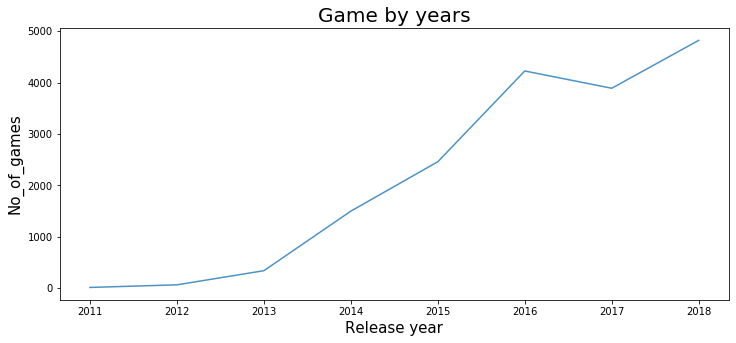

In [11]:
plt.figure(figsize=(12,5))
count=df_steam["year"].value_counts()
g = sns.lineplot(count.index, count.values, alpha=0.8)
g.set_title("Game by years", fontsize=20)
g.set_xlabel("Release year", fontsize=15)
g.set_ylabel("No_of_games", fontsize=15)

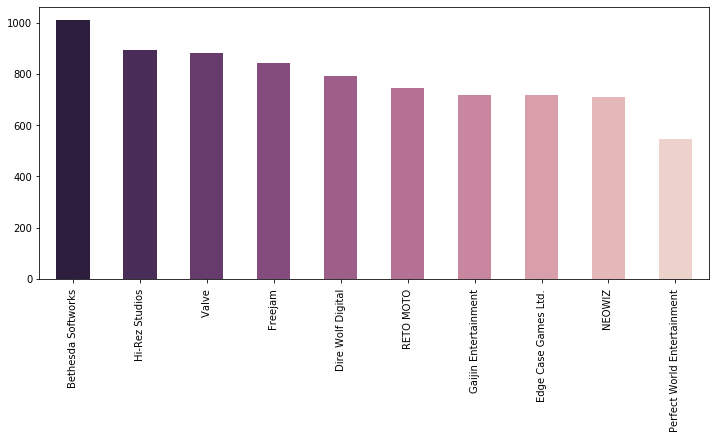

In [12]:
plt.figure(figsize=(12,5))
df_steam['publisher'].value_counts().head(10).sort_values(ascending = False).plot(kind="bar", 
                                                    color=sns.cubehelix_palette(n_colors=10, reverse=True))

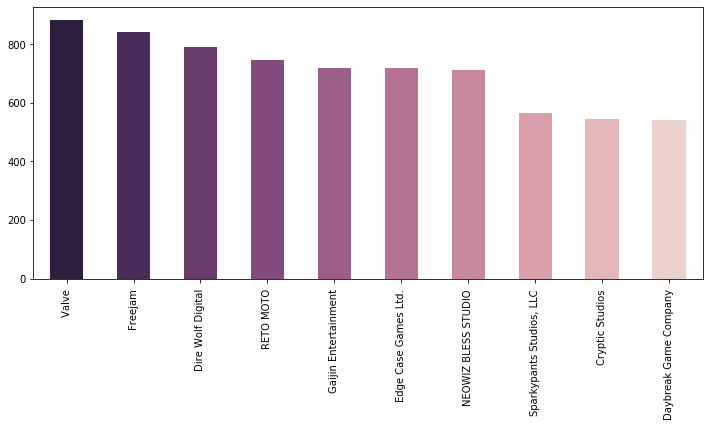

In [13]:
plt.figure(figsize=(12,5))
df_steam['developer'].value_counts().head(10).sort_values(ascending = False).plot(kind="bar", 
                                                    color=sns.cubehelix_palette(n_colors=10, reverse=True))

## Feature engineering

### separate tags 

In [5]:
## train dataset
# convert string object to list
tags = df_steam["tags"].apply(lambda x: ast.literal_eval(x))
tags = tags.apply(lambda x: ','.join(x))

# count unique tag frequency
count_vec = CountVectorizer()
tags = count_vec.fit_transform(tags)

# create tag vector
tags_vec = []
for tag, idx in count_vec.vocabulary_.items():
    tags_vec.append(tag)

# create dataframe
df_tags = pd.DataFrame(data=tags.todense(), columns=tags_vec)
df_tags.head(3)

,horror,free,to,play,cute,first,person,singleplayer,psychological,indie,...,resource,gun,education,puzzle,america,masterpiece,family,friendly,mod,classic
0,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [6]:
## test dataset
# convert string object to list
test_tags = df_test["tags"].apply(lambda x: ast.literal_eval(x))
test_tags = test_tags.apply(lambda x: ','.join(x))

# count unique tag frequency
test_cv = CountVectorizer()
test_tags = test_cv.fit_transform(test_tags)

# create tag vector
test_tags_vec = []
for tag, idx in test_cv.vocabulary_.items():
    test_tags_vec.append(tag)

# create dataframe
df_test_tags = pd.DataFrame(data=test_tags.todense(), columns=test_tags_vec)
df_test_tags.head(3)

,fps,multiplayer,shooter,action,team,based,competitive,tactical,first,person,...,book,magic,board,battle,royale,zombies,violent,walking,simulator,gore
0,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0


In [7]:
# keep tags appearing both in train and test dataset, remove tags only appearing in the test dataset
df_test_tags = df_test_tags[df_test_tags.columns.intersection(tags_vec)]
feature_difference = set(df_tags) - set(df_test_tags)
df_feature_difference = pd.DataFrame(data=np.zeros((df_test_tags.shape[0], 
                                                len(feature_difference))),
                                 columns=list(feature_difference))
df_test_tags = df_test_tags.join(df_feature_difference)
df_test_tags.shape

(8045, 162)

### Create title and publisher dummy 

In [8]:
factors = ['title', 'publisher']

## train dataset
for var in factors:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df_steam[var], prefix=var, drop_first=True)
    df_steam = pd.concat([df_steam,cat_list], axis = 1)
    df_steam = df_steam.drop(var, 1)
    
## test dataset
for var in factors:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df_test[var], prefix=var, drop_first=True)
    df_test = pd.concat([df_test,cat_list], axis = 1)
    df_test = df_test.drop(var, 1)
    
    
df_test = df_test[df_test.columns.intersection(df_steam.columns.values)]
fd = set(df_steam) - set(df_test)
df_fd = pd.DataFrame(data=np.zeros((df_test.shape[0], len(fd))),
                                 columns=list(fd))
df_test = df_test.join(df_fd)
df_test.shape

(8045, 89)

### Word tokenization

In [14]:
# convert text to lower case 
train_review = df_steam["user_review"].str.lower()

# remove numbers
train_review = train_review.replace("\d+", '')

# words Tokenization
train_review = train_review.apply(word_tokenize)

# remove non-English words
engwords = set(nltk.corpus.words.words())
train_review = train_review.apply(lambda x: [w for w in x if w in engwords])

# remove punctuation
punctuations = list(string.punctuation)
train_review = train_review.apply(lambda x: 
            [i.strip("".join(punctuations)) for i in x if i not in punctuations])

# handle negations
def handleNegations (text):
    for i in range(len(text)-1):
        if text[i] == "not":
            text[i] == ""
            text[i+1] =="not_"+text[i+1]
        elif "n't" in text[i]:
            text[i] = text[i].replace("n't", "")
            text[i+1] = "not_"+text[i+1]
        else: continue
    return text

train_review = train_review.apply(handleNegations)

# remove stop words 
stop_words=set(stopwords.words("english"))
new_stop = ['http','www','com']
stop_words.update(new_stop)
train_review = train_review.apply(lambda x: [item for item in x if item not in stop_words])

# stem words 
porter_stemmer = PorterStemmer()
stemmed_train_review = train_review.apply(lambda x: [porter_stemmer.stem(y) for y in x])

print(stemmed_train_review)

0        [hear, creepi, paus, moment, write, review, wa...
1        [best, game, better, sam, pepper, account, nee...
2        [iffi, know, play, easi, master, made, floor, ...
3        [great, game, fun, color, side, note, though, ...
4        [mani, cute, tag, right, next, horror, tag, fi...
                               ...                        
17489    [singl, today, free, littl, competit, game, gr...
17490    [older, game, sure, charm, special, place, hea...
17491    [frist, amaz, still, great, friendli, matur, l...
17492    [cool, game, thing, realli, ridabl, transport,...
17493    [game, sinc, littl, alway, sinc, still, rememb...
Name: user_review, Length: 17494, dtype: object


In [11]:
# convert text to lower case 
test_review = df_test["user_review"].str.lower()

# remove numbers
test_review = test_review.replace("\d+", '')

# words Tokenization
test_review = test_review.apply(word_tokenize)

# remove non-English words
test_review = test_review.apply(lambda x: [w for w in x if w in engwords])

# remove punctuation
test_review = test_review.apply(lambda x: 
            [i.strip("".join(punctuations)) for i in x if i not in punctuations])

# handle negations
test_review = test_review.apply(handleNegations)

# remove stop words 
test_review = test_review.apply(lambda x: [item for item in x if item not in stop_words])

# stem words 
porterStemmer = PorterStemmer()
stemmed_test_review = test_review.apply(lambda x: [porterStemmer.stem(y) for y in x])

print(stemmed_test_review)

0       [nice, graphic, new, listen, bit, much, import...
1       [would, recommend, get, current, state, hit, r...
2       [edit, tri, go, recent, dramat, gotten, wors, ...
3       [game, great, commun, match, mayb, fine, time,...
4       [thank, long, time, ago, would, play, around, ...
                              ...                        
8040    [earli, access, posit, good, idea, lot, fun, p...
8041    [review, spend, money, would, seam, better, al...
8042    [realli, get, except, bug, mean, stand, chanc,...
8043    [sauci, suggest, life, new, tast, tower, defen...
8044    [see, peopl, play, say, game, bad, side, see, ...
Name: user_review, Length: 8045, dtype: object


### sentiment score and text length  

In [13]:
## train dataset

# define function to get sentiment score
def get_polarity (content):
    score = TextBlob(content).sentiment.polarity
    return score

df_steam['reviewPolarity'] = stemmed_train_review.apply(lambda x:get_polarity(str(x)))

In [14]:
## test dataset
df_test["reviewPolarity"] = stemmed_test_review.apply(lambda x:get_polarity(str(x)))
df_test["reviewLength"] = df_test["user_review"].apply(lambda x:len(str(x)))

### Word2vec feature extraction 

In [15]:
# train word2vec model -> learn the weights of the hidden layer
# size: num of neural network layers 
# window: maximum distance between the target word and its neighboring word
word2vec_model = Word2Vec(stemmed_train_review, size=150, window=5, min_count=5, workers=3, iter=10)
print(word2vec_model)

# summarize vocabulary
words = list(word2vec_model.wv.vocab)
#print(words)

Word2Vec(vocab=5024, size=150, alpha=0.025)


In [16]:
# save and load model 
word2vec_model.save("word2vec.model")
word2vec_model = Word2Vec.load("word2vec.model")
# continue train the model 
#word2vec_model.train(stemmed_test_review,total_examples=len(stemmed_test_review),epochs=10)

In [24]:
word2vec_model.wv.most_similar('creepi')

[('cute', 0.845608115196228),
 ('scari', 0.8072538375854492),
 ('cardboard', 0.7835646867752075),
 ('chase', 0.7595124244689941),
 ('spooki', 0.7523843050003052),
 ('ador', 0.7320796847343445),
 ('scare', 0.720510721206665),
 ('babi', 0.7106027007102966),
 ('terrifi', 0.7073004841804504),
 ('puppet', 0.705169677734375)]

In [34]:
# compute the cosine similarity between the two specified words using word vectors (embeddings)
word2vec_model.wv.similarity(w1="childish", w2="roam")

0.19047758

In [54]:
def doc_vec(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in word2vec_model.wv.vocab]
    try:
        return np.mean(word2vec_model.wv[doc], axis=0)
    except ValueError:
        return np.zeros(150)

# prepare train data
X_train_word2vec = list(stemmed_train_review.apply(doc_vec))
train_copy = df_steam.drop(["tags", "review_id", "user_review", 'user_suggestion', 
                           "overview", 'developer'], 1)
X_train = pd.concat([pd.DataFrame(X_train_word2vec), df_tags, train_copy], axis=1)

# prepare test data
X_test_word2vec = list(stemmed_test_review.apply(doc_vec))
test_copy = df_test.drop(["tags", "review_id", "user_review",'user_suggestion', "overview", 'developer'], 1)
X_test = pd.concat([pd.DataFrame(X_test_word2vec), df_test_tags, test_copy], axis=1)

y_train = df_steam["user_suggestion"]

In [55]:
# drop nan values
X_train = pd.concat([X_train, y_train], axis=1).dropna()
y_train = X_train["user_suggestion"]
X_train = X_train.drop("user_suggestion", 1)
X_test = X_test.dropna()

## Machine learning model 

In [56]:
clf = svm.SVC()
clf.fit(X_train, y_train)

# predicting the test set results
y_pred_svm = clf.predict(X_test)

print("The in-sample accuracy score of SVM is: ",clf.score(X_train, y_train))

The in-sample accuracy score of SVM is:  0.570974820974821


In [62]:
logreg = LogisticRegression(max_iter=10000, random_state=0)
logreg.fit(X_train, y_train)

# predicting the test set results
y_pred_logit = logreg.predict(X_test)

print("The in-sample accuracy score of Logistic Regression is: ", 
                              logreg.score(X_train, y_train))
print("\n")
print(y_pred_logit)

The in-sample accuracy score of Logistic Regression is:  0.8355278355278355


[1 0 1 ... 1 1 1]


In [59]:
df_final1 = pd.concat([steam_test, pd.DataFrame(y_pred_svm)], axis=1)
df_final1.head(3)

,review_id,title,year,user_review,0
0,1603,Counter-Strike: Global Offensive,2015.0,"Nice graphics, new maps, weapons and models. B...",1.0
1,1604,Counter-Strike: Global Offensive,2018.0,I would not recommend getting into this at its...,1.0
2,1605,Counter-Strike: Global Offensive,2018.0,Edit 11/12/18I have tried playing CS:GO recent...,1.0


In [63]:
df_final2 = pd.concat([steam_test, pd.DataFrame(y_pred_logit)], axis=1)
df_final2.head(3)

,review_id,title,year,user_review,0
0,1603,Counter-Strike: Global Offensive,2015.0,"Nice graphics, new maps, weapons and models. B...",1.0
1,1604,Counter-Strike: Global Offensive,2018.0,I would not recommend getting into this at its...,0.0
2,1605,Counter-Strike: Global Offensive,2018.0,Edit 11/12/18I have tried playing CS:GO recent...,1.0
